# Spatial Autocorrelation

This is an example of Spatial Statistics,  which look at the relationship of other information with spatial locations,   how are various properties spread out
over the landscape,  and are these spatial relationships random or non-random.

Humans are very good at detecting patterns,  but we are also good at imagining relationships where none exist.

The issue of "cancer clusters" is one area of public health concern for example.  We will spend a bit of time working on these types of statistics.

https://pysal.org/esda/notebooks/spatialautocorrelation.html

In [6]:
!pip install watermarker

  Using cached watermarker-1.1.tar.gz (2.8 kB)
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of watermarker to determine which version is compatible with other requirements. This could take a while.
  Using cached watermarker-1.0.tar.gz (2.7 kB)
  Preparing metadata (setup.py) ... done
ERROR: Cannot install watermarker==1.0 and watermarker==1.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    watermarker 1.1 depends on pil
    watermarker 1.0 depends on pil

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [7]:
#  There is an external add on for jupyter notebook that will "watermark" the notebook, giving a lot of information
# about the python version used

%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-03-12T22:24:56.842186+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.58+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



In [9]:
! pip install esda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 14.3 MB/s eta 0:00:00


### Windows Watermark Result

Last updated: 2022-03-10T15:15:08.133503-05:00

Python implementation: CPython
Python version       : 3.7.11
IPython version      : 7.31.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 13, GenuineIntel
CPU cores   : 16
Architecture: 64bit

Mac Watermark

Last updated: 2022-03-10T16:28:49.529784-05:00

Python implementation: CPython
Python version       : 3.7.11
IPython version      : 7.31.1

Compiler    : Clang 10.0.0
OS          : Darwin
Release     : 19.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

In [10]:
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline

In [11]:
%watermark -iv

geopandas : 0.13.2
libpysal  : 4.10
matplotlib: 3.7.1
pandas    : 1.5.3
numpy     : 1.25.2
esda      : 2.5.1



### Windows package watermarks

esda      : 2.3.6
pandas    : 1.3.5
matplotlib: 3.5.1
libpysal  : 4.5.1
numpy     : 1.21.5
geopandas : 0.9.0

Mac Watermarks

pandas    : 1.3.5
esda      : 2.4.1
geopandas : 0.9.0
matplotlib: 3.5.1
libpysal  : 4.5.1
numpy     : 1.21.2

The data we are using is a map of the neighborhoods of Berlin,  and some data on air-bnb housing prices within each neighborhood,  see the pysal package website above to see the discussion of how this data was generated.  It was webscraped from air-bnb website listings.

Note that the census data we worked with last time had a similar format and relationship to the map of census blocks in Buffalo

Any data with geographic location information (lat and long say) could be easily mapped into neighbor hoods in Buffalo,  using the neighborhoods outlines within
Buffalo

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
#infile_1="C:\\Users\\hdavi\\Dropbox\\Data_Analytics\\DAT_512\\Example_data\\Berlin_Neighborhoods\\berlin-neighbourhoods.geojson.txt"
infile_1="/content/drive/MyDrive/Colab Notebooks/Spring 2024/DAT_512-Stat.-Approaches-to-Big-Data/Data/berlin-neighbourhoods.geojson.txt"

gdf = gpd.read_file(infile_1)

In [14]:
#infile_2="C:\\Users\\hdavi\\Dropbox\\Data_Analytics\\DAT_512\\Example_data\\Berlin_Neighborhoods\\berlin-listings.csv"
infile_2="/content/drive/MyDrive/Colab Notebooks/Spring 2024/DAT_512-Stat.-Approaches-to-Big-Data/Data/berlin-listings.csv"

bl_df = pd.read_csv(infile_2)
geometry = [Point(xy) for xy in zip(bl_df.longitude, bl_df.latitude)]
crs = {'init': 'epsg:4326'}
bl_gdf = GeoDataFrame(bl_df, crs=crs, geometry=geometry)


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


the two data frames have slightly different CRS specifications, the code threw an error message, so this is just altering one CRS to match
the other before we do a join, to map the media prices from the one dataframe onto the neighborhood geolocation data from the other

In [15]:
bl_gdf.to_crs(epsg=4326,inplace=True)

In [16]:
bl_gdf['price'] = bl_gdf['price'].astype('float32')
sj_gdf = gpd.sjoin(gdf, bl_gdf, how='inner', op='intersects', lsuffix='left', rsuffix='right')
median_price_gb = sj_gdf['price'].groupby([sj_gdf['neighbourhood_group']]).mean()
median_price_gb

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


neighbourhood_group
Charlottenburg-Wilm.        58.556408
Friedrichshain-Kreuzberg    55.492809
Lichtenberg                 44.584270
Marzahn - Hellersdorf       54.246754
Mitte                       60.387890
Neukölln                    45.135948
Pankow                      60.282516
Reinickendorf               43.682465
Spandau                     48.236561
Steglitz - Zehlendorf       54.445683
Tempelhof - Schöneberg      53.704407
Treptow - Köpenick          51.222004
Name: price, dtype: float32

In [17]:
gdf = gdf.join(median_price_gb, on='neighbourhood_group')
gdf.rename(columns={'price': 'median_pri'}, inplace=True)
gdf.head(15)

,neighbourhood,neighbourhood_group,geometry,median_pri
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",60.282516
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52...",60.282516
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52...",58.556408
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.39630, 13.70926 52...",51.222004
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.40850, 13.73773 52...",51.222004
5,Biesdorf,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.56643 52.53510, 13.56697 52...",54.246754
6,Nord 1,Reinickendorf,"MULTIPOLYGON (((13.33669 52.62265, 13.33663 52...",43.682465
7,West 5,Reinickendorf,"MULTIPOLYGON (((13.28138 52.59958, 13.28158 52...",43.682465
8,Frankfurter Allee Nord,Friedrichshain-Kreuzberg,"MULTIPOLYGON (((13.45320 52.51682, 13.45321 52...",55.492809
9,Buch,Pankow,"MULTIPOLYGON (((13.46449 52.65055, 13.46457 52...",60.282516


How many null values to we have?

We will replace these with the median,  so an imputation

In [18]:
pd.isnull(gdf['median_pri']).sum()

2

In [19]:
gdf['median_pri'].fillna((gdf['median_pri'].mean()), inplace=True)

Plot the median price over the landscape

<Axes: >

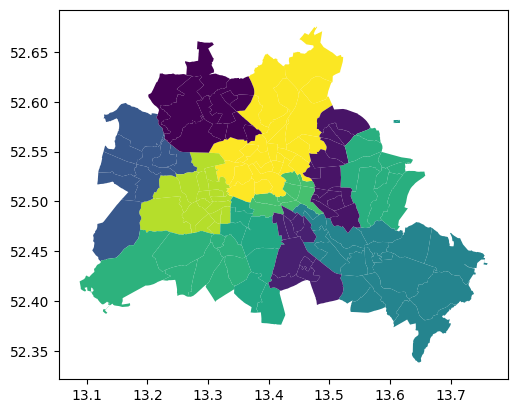

In [20]:
gdf.plot(column='median_pri')

A bit more control plot

It took forever to figure out that edgecolor controlled the boundary colors.  The default was white and that was hard to see...

In [22]:
! pip install mapclassify

<Axes: >

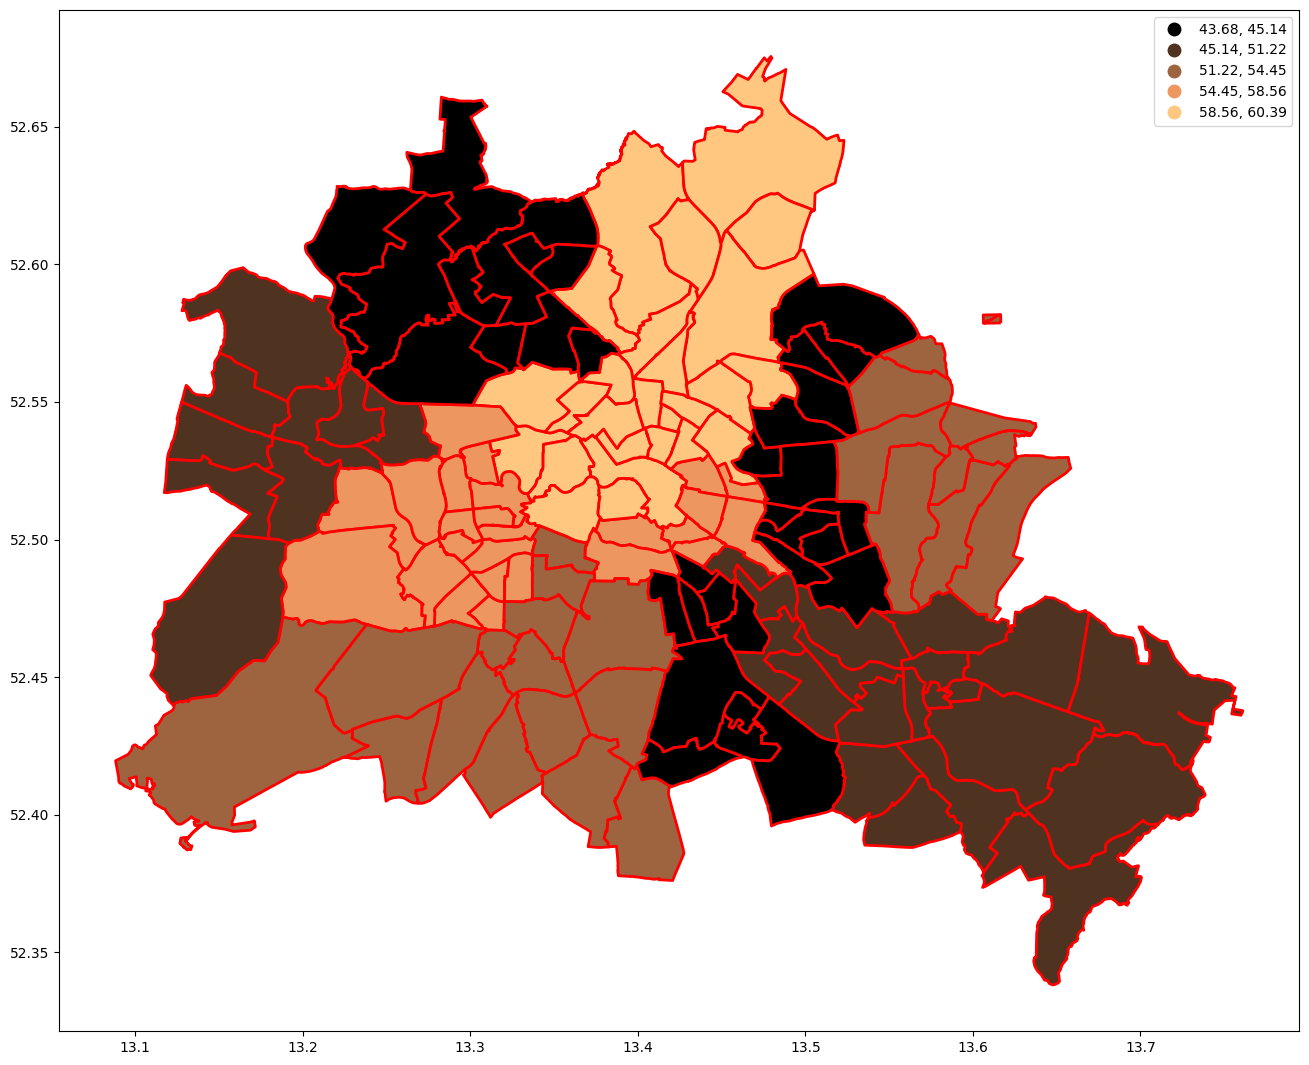

In [23]:
fig, ax = plt.subplots(figsize=(16,14), subplot_kw={'aspect':'equal'})
gdf.plot(column='median_pri', scheme='Quantiles', k=5, cmap='copper', legend=True, ax=ax,linewidth=2,edgecolor="r")
#ax.set_xlim(150000, 160000)
#ax.set_ylim(208000, 215000)

For more colormaps in matplotlib

https://matplotlib.org/stable/tutorials/colors/colormaps.html

# Tests of the significance of observed spatial patterns

From this plot it looks like the neighborhood (spatial location) has a lot to do with the median Air-BNB housing price

but humans see patterns all the time, is it non-random?

We will first compute a measure of spatial similarity, in this case the "Queen Contiguity"

This is a "spatial weighting" for each neighborhood,  it describes which neighborhoods (polygon boundaries) are "close" to each other on some
scale of what it means to be close

Contiguity- A and B are close if A is adjacent to B
    
    Rook Contiguity- sharing a segment of a border
    
    Queen Contiguity-sharing one or more points along the border
    
    First order contiguity- being in contact under Rook or Queen Contiguity
    
    Second order contiguity- have a shared neighbor under Rook or Queen- ie a next nearest neighbor


Distance-  A and B are close if A is located a short distance from B,  based on some measure of distance

    Euclidean
    Great circle- surface of the earth distance
  
    use K-nearest neighbors ideas
    or Threshold - within some boundary/threshold distance
    

In [24]:
df = gdf
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'

<ipython-input-24-a2341e16343b>:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq =  lps.weights.Queen.from_dataframe(df)
/usr/local/lib/python3.10/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:1484: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid
/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:1484: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid
/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:1484: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid
/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:1484: UserWarning: Geometry i

(<Figure size 640x480 with 1 Axes>, <Axes: >)

<Figure size 1600x1400 with 0 Axes>

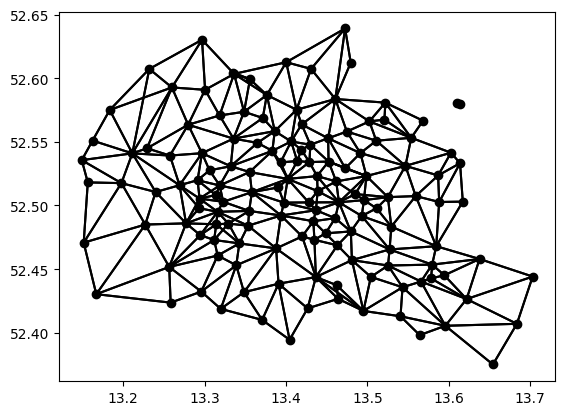

In [25]:
ax=plt.figure(figsize=(16,14))
wq.plot(gdf)


Okay, so this is what the connectiviy of the Berlin neighborhoods looks like

We compute a spatial lag, the average value of the variable over the neighboring locations, so each Berlin value has a lag

In [26]:
y = df['median_pri']
ylag = lps.weights.lag_spatial(wq, y)

In [27]:
ylag

array([56.9625061 , 60.28251648, 56.37749926, 51.22200394, 51.22200394,
       50.52180099, 43.6824646 , 45.63422012, 52.65491422, 60.28251648,
       53.64180374, 52.73586273, 52.73586273, 56.47182541, 47.83247757,
       58.58870177, 60.33520317, 59.60296903, 60.38788986, 60.02159348,
       51.80624199, 57.94034958, 52.84482813, 53.40314266, 57.90522512,
       60.28251648, 60.28251648, 55.79730334, 56.79401737, 50.81182589,
       59.01427841, 60.29756982, 60.28251648, 50.86356888, 60.3220315 ,
       60.28251648, 55.48057556, 54.42881557, 60.32466583, 59.50179418,
       54.42846909, 58.55640793, 58.55640793, 57.73426285, 57.47818544,
       57.74774106, 56.13040733, 48.23656082, 48.23656082, 53.74621709,
       55.11957245, 45.95951271, 51.67650986, 54.1985906 , 51.45368042,
       52.36880302, 54.44568253, 54.44568253, 50.84825389, 56.50104523,
       53.92108345, 55.9956289 , 50.49590378, 49.14499828, 48.61369433,
       49.70049   , 49.32550866, 51.22200394, 51.22200394, 47.80

We will then convert the quantiles of the lags

In [28]:
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)

In [29]:
ylagq5

Quantiles

   Interval      Count
----------------------
[43.68, 48.88] |    28
(48.88, 51.22] |    34
(51.22, 54.12] |    22
(54.12, 57.88] |    28
(57.88, 60.39] |    28

Now a plot of quantiles by neighborhood

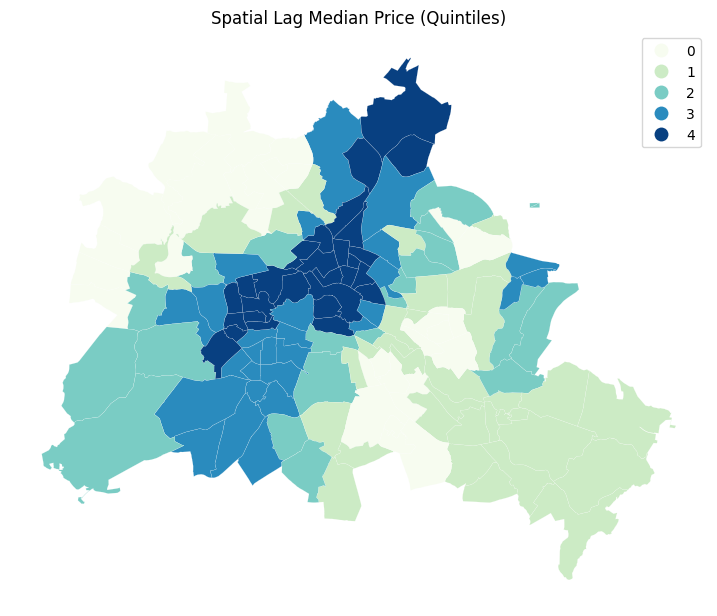

In [30]:
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Median Price (Quintiles)")

plt.show()

We can now plot the price and the lag of the price.

The lag is like a local averaging of price around the neighborhood

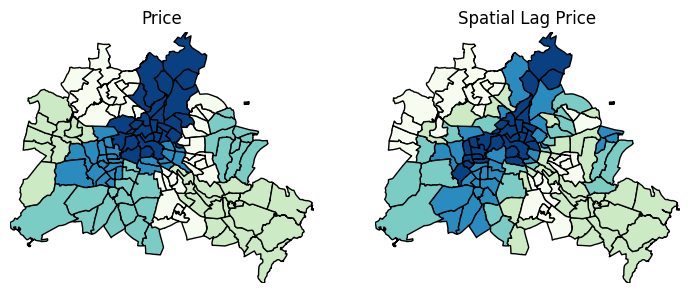

In [31]:
df['lag_median_pri'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
df.plot(column='median_pri', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Price")
df.plot(column='lag_median_pri', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Price")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [32]:
y.median()

# y is the median airbnb price in a neighbor hood

53.704407

In [33]:
yb = y > y.median()
sum(yb)

# yb,  neighborhoods above median.  We'll plot this below,  a binary plot of high and low priced neighborhoods

68

In [34]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb]
df['yb'] = yb

<Axes: >

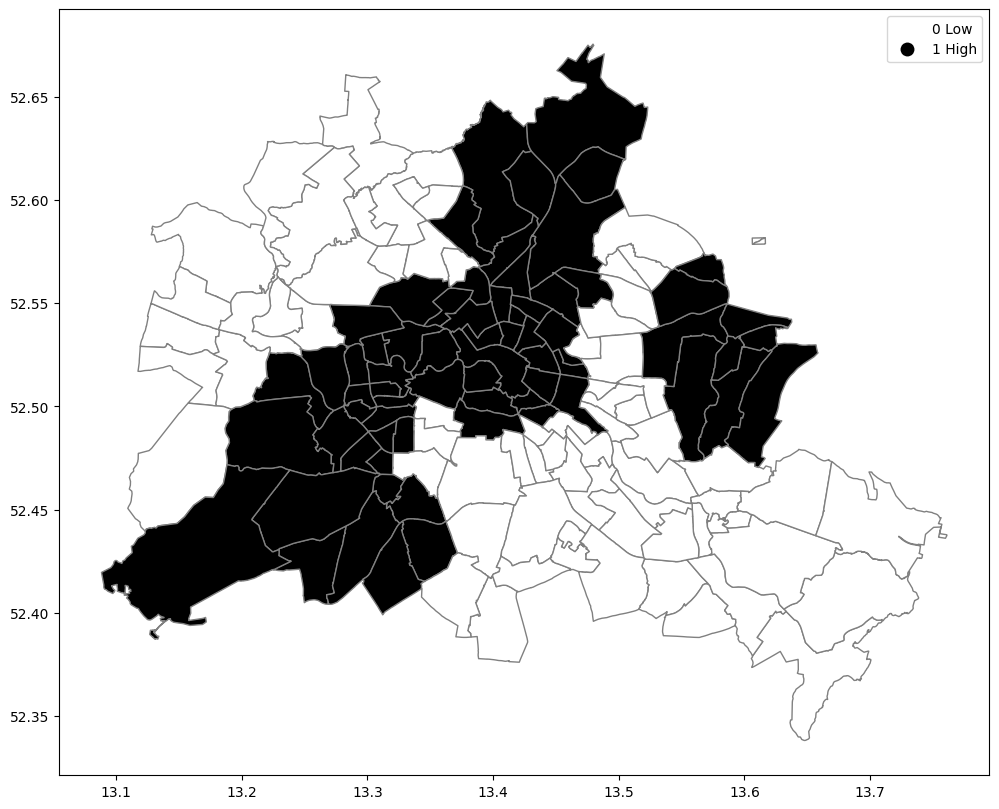

In [35]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

## Measuring Spatial Autocorrelation

Each pair of neighboring locations has a "join",  the pairing of the categories BB, BW or WW

We can compute this based on our list of queen weights

In [36]:
import esda
yb = 1 * (y > y.median()) # convert back to binary
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wq)


<ipython-input-36-a65f1d36ec70>:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq =  lps.weights.Queen.from_dataframe(df)
/usr/local/lib/python3.10/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


We can then plot out the joining seen by type,  BB,BW,WW

In [37]:
jc.bb

164.0

In [38]:
jc.ww

149.0

In [39]:
jc.bw

73.0

Count of all possible joins

In [40]:
jc.bb + jc.ww + jc.bw

386.0

In [41]:
wq.s0 / 2

386.0

In [42]:
jc.bb

164.0

## Join Count Analysis,  from esra

Are the observed number of BB and WW joins,   meaning shared categories between neighbors consistent with a random placement of air-bnb prices across the landscape?

Or is there a tendency for neighborhoods to have similar prices,  so there is a grouping of price, or a dependence of price on the spatial location?

In other words,  is there a meaningful dependence of price on neighborhood?

The esda.join_counts.Join_Counts (a function so nice, they named it twice) function uses a randomization test to see what the WW, BB and WB values
would look like if the prices were randomly assigned to neighborhoods

This is a permutation test,  we just shuffle the prices and recompute

We can compute the mean number of bb joins, and a histogram of the bb joins over the randomization process

This will tell us if the measured number of bb joins (jc.bb=164) is consistent with random pricing

If jc.bb is larger than the random results,   the prices are clustered, or attracting

If jc.bb is less than the random results,  the prices are self-avoiding.    Bird nests are often self-avoiding, as one example.  Gas stations migh self-avoid as
well

In [43]:
jc.mean_bb

90.70170170170171

Our observed count of bb was 164, well above the simulation mean.  Let's look at the histogram.  We plot the simulation bb outcomes and a line for the observed
bb count

<ipython-input-44-e6188732e376>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(jc.sim_bb, shade=True)


Text(0.5, 0, 'BB Counts')

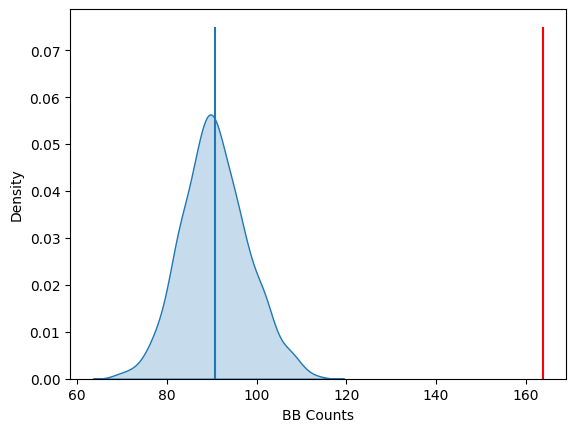

In [44]:
import seaborn as sbn
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')

What does this mean?

We can estimate a p-value, the chance that this large a value of bb could be produced by a random simulation

In [45]:
jc.p_sim_bb

0.001

## Continuous Case

In the esra.join_count simulation,  we used a discrete (binary) category.  We can used continuous variables and test for spatial autocorrelation

spatial autocorrelation just means that being spatially close influence the probability of a variable value

In [46]:
wq.transform = 'r'

In [47]:
y = df['median_pri']

Use Moran's test of spatial autocorrelation

This is a correlation score computed only for neighboring locations,  so it is the correlation of the values in neighboring locations

It is called Moran's I

Here is the value

In [48]:
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.6563069331329718

In the esra implementation, there is permutation test of the value of Moran's I based on simulations,  using the same ideas that we used for
the binary join test above,

again, we compared the observed Moran I value to the simulation results

<ipython-input-49-9824c465aaaf>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(mi.sim, shade=True)


Text(0.5, 0, "Moran's I")

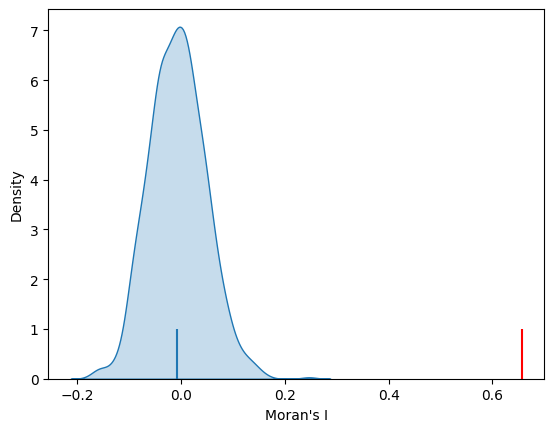

In [49]:
import seaborn as sbn
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

In [50]:
mi.p_sim

0.001

## Local Autocorrelation

This allows calculation of local Moran statistics

Each local value of Moran's I is stored and can be plotted,  so this shows autocorrelation levels across the map

Below a lot of the calculations above are repeated

In [51]:
np.random.seed(12345)
import esda

In [52]:
wq.transform = 'r'
lag_price = lps.weights.lag_spatial(wq, df['median_pri'])

Showing the price lag versus price

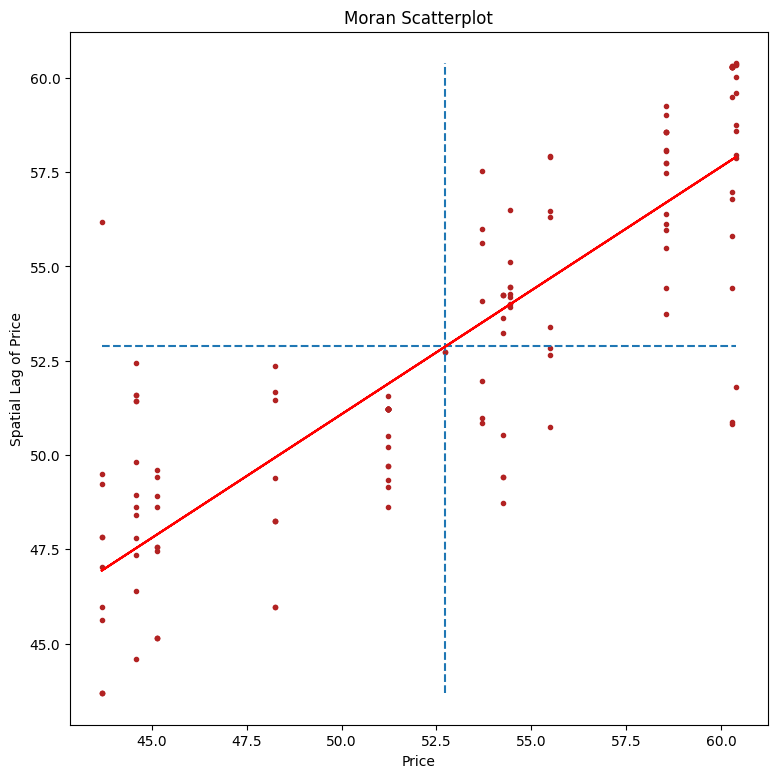

In [53]:
price = df['median_pri']
b, a = np.polyfit(price, lag_price, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(price, lag_price, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle='--')
 # dashed horizontal at mean of lagged price
plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(price, a + b*price, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Price')
plt.xlabel('Price')
plt.show()

## This set of commands has run on a Mac, but doesn't seem to be running on a PC,  so it is probably a version issue.


After finding the Watermark function,  I suspect it is the version of esda used, on a windows machine, try updating esda

In [55]:
wq?

In [54]:
li = esda.moran.Moran_Local(y, wq)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<intrinsic _impl>) found for signature:
 
 >>> _impl(array(float32, 2d, C), array(float64, 1d, C))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Intrinsic in function 'dot_2_impl.<locals>._impl': File: numba/np/linalg.py: Line 543.
    With argument(s): '(array(float32, 2d, C), array(float64, 1d, C))':
   Rejected as the implementation raised a specific error:
     TypingError: '@' arguments must all have the same dtype
  raised from /usr/local/lib/python3.10/dist-packages/numba/np/linalg.py:563

During: resolving callee type: Function(<intrinsic _impl>)
During: typing of call at /usr/local/lib/python3.10/dist-packages/numba/np/linalg.py (582)


File "../usr/local/lib/python3.10/dist-packages/numba/np/linalg.py", line 582:
            def _dot2_codegen(context, builder, sig, args):
                <source elided>

        return lambda left, right: _impl(left, right)
        ^

During: typing of intrinsic-call at /usr/local/lib/python3.10/dist-packages/esda/moran.py (1826)

File "../usr/local/lib/python3.10/dist-packages/esda/moran.py", line 1826:
def _moran_local_crand(i, z, permuted_ids, weights_i, scaling):
    <source elided>
    zi, zrand = _prepare_univariate(i, z, permuted_ids, other_weights)
    return zi * (zrand @ other_weights + self_weight * zi) * scaling
    ^

During: resolving callee type: type(CPUDispatcher(<function _moran_local_crand at 0x7f6d43bcaa70>))
During: typing of call at /usr/local/lib/python3.10/dist-packages/esda/crand.py (328)

During: resolving callee type: type(CPUDispatcher(<function _moran_local_crand at 0x7f6d43bcaa70>))
During: typing of call at /usr/local/lib/python3.10/dist-packages/esda/crand.py (328)

During: resolving callee type: type(CPUDispatcher(<function _moran_local_crand at 0x7f6d43bcaa70>))
During: typing of call at /usr/local/lib/python3.10/dist-packages/esda/crand.py (328)


File "../usr/local/lib/python3.10/dist-packages/esda/crand.py", line 328:
def compute_chunk(
    <source elided>
        mask[chunk_start + i] = False
        rstats = stat_func(chunk_start + i, z, permuted_ids, weights_i, scaling)
        ^


Again, we run a simulation test,  with constrained permutations at each location.

below 66 locations have local correlations that are not consistent with random, chance distributions of price

In [ ]:
li.q

In [ ]:
(li.p_sim < 0.05).sum()

There are 4 types of "abnormal" local spatial correlation values

hotspots, with higher than expected prices
coldsplots, with lower than expected
donuts with a low value surrounded by high values
diamonds with a high value surrounded by low values

In [ ]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [ ]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

In [ ]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [ ]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

In [ ]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [ ]:
spots = ['n.sig.', 'doughnut']
labels = [spots[i] for i in doughnut*1]

In [ ]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['lightblue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [ ]:
spots = ['n.sig.', 'diamond']
labels = [spots[i] for i in diamond*1]

In [ ]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['pink', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [ ]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

In [ ]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

In [ ]:

from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()